In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure
from pathlib import Path
import os
import wave
import keras
import seaborn as sns
import librosa
import soundfile as sf
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from numpy import mean
from numpy import std
import tensorflow as tf
from numpy import dstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from scipy.io import wavfile
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from datetime import date
today = date.today()
f_date=today.strftime("%d_%m_%y")
os.mkdir("/content/gdrive/My Drive/all_disease_classification/train_on_"+(f_date))
new_loc="/content/gdrive/My Drive/all_disease_classification/train_on_"+(f_date)

In [ ]:
import scipy
sig_dict = scipy.io.loadmat('/content/gdrive/MyDrive/all_disease_classification/7class_train_img.mat')
X=sig_dict['train_img']

In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/all_disease_classification/Labels.xlsx',header=None)
labels.columns=["Lung Sound"]
class_label_onehot=pd.get_dummies(labels)
Y=np.array(class_label_onehot);
print(X.shape)
print(Y.shape)

(18906, 64, 64, 3)
(18906, 7)


In [ ]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=100, 
    min_delta=0.001, 
    mode='max'
)

In [ ]:
def mobile_inception(dim, output_neurons, output_activation):
    print("\nTRAINING ON Lightweight MODEL:-")

    
    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv2D(filters[0], kernel_size = (1,1))(x)
            t1 = LeakyReLU()(t1)

            # for mid-level features
            t2 = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv2D(filters[1], kernel_size = (1,1))(t2)
            t2 = LeakyReLU()(t2)

            # for high-level features
            t3 = DepthwiseConv2D(kernel_size = (5,5), strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv2D(filters[2], kernel_size = (1,1))(t3)
            t3 = LeakyReLU()(t3)

            # for most-significant features
            t4 = MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')(x)
            t4 = Conv2D(filters[3], kernel_size = (1,1))(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])
        
        return x
        
        
    input = Input(shape = dim)
    
    k = 16
    
    x = Conv2D(filters = k, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters = 2*k, kernel_size = (1,1))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
        
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x=  Dense(40, 'relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(output_neurons, output_activation)(x)
    
    model = Model(inputs = input, outputs = output)    
    
    return model

In [ ]:
dim = (64,64,3)
output_neurons = 7
output_activation = 'softmax'
from keras import backend as Ke
Ke.clear_session()
model = mobile_inception(dim, output_neurons, output_activation)
#model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


TRAINING ON Lightweight MODEL:-


In [ ]:
    p=10;batch=256;
    print('Random_seed_value== '+str(p))
    X_train_1,X_test,Y_train_1,Y_test=train_test_split(X,Y,test_size=0.1,random_state=p)
    X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=p)

Random_seed_value== 10


In [ ]:
    print("================================================================================================")
    from keras import backend as Ke
    Ke.clear_session()
    model = mobile_inception(dim, output_neurons, output_activation)
    opt =tf.keras.optimizers.Adam(learning_rate=0.008) 
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=batch, epochs=400, verbose=1,validation_data=(X_val, Y_val))#,callbacks=[custom_early_stopping])    


TRAINING ON Lightweight MODEL:-
Epoch 1/400
60/60 [==============================] - 15s 29ms/step - loss: 1.7217 - accuracy: 0.3454 - val_loss: 1.6514 - val_accuracy: 0.3561
Epoch 2/400
60/60 [==============================] - 1s 17ms/step - loss: 1.5345 - accuracy: 0.3842 - val_loss: 1.3726 - val_accuracy: 0.4395
Epoch 3/400
60/60 [==============================] - 1s 17ms/step - loss: 1.3410 - accuracy: 0.4558 - val_loss: 1.2670 - val_accuracy: 0.4941
Epoch 4/400
60/60 [==============================] - 1s 17ms/step - loss: 1.1793 - accuracy: 0.5247 - val_loss: 1.1348 - val_accuracy: 0.5253
Epoch 5/400
60/60 [==============================] - 1s 17ms/step - loss: 1.0512 - accuracy: 0.5838 - val_loss: 1.0389 - val_accuracy: 0.5787
Epoch 6/400
60/60 [==============================] - 1s 17ms/step - loss: 0.9838 - accuracy: 0.6065 - val_loss: 0.9782 - val_accuracy: 0.5940
Epoch 7/400
60/60 [==============================] - 1s 17ms/step - loss: 0.9148 - accuracy: 0.6403 - val_loss: 0.

<Figure size 432x288 with 0 Axes>

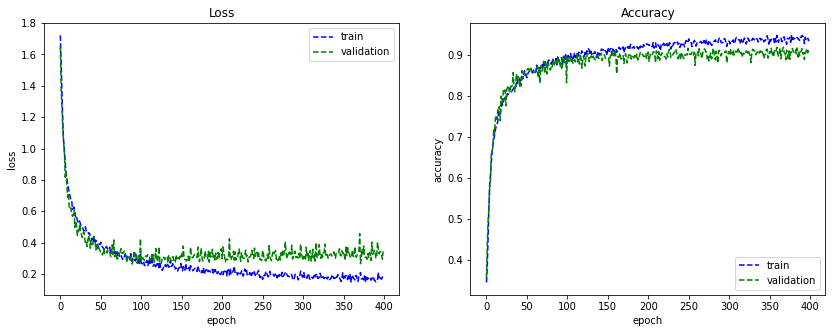

In [ ]:
    plt.figure(1)
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.plot(history.history['loss'],'b--')
    plt.plot(history.history['val_loss'],'g--')
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
 
    plt.subplot(122)
    plt.plot(history.history['accuracy'],'b--')
    plt.plot(history.history['val_accuracy'],'g--')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()   
    

In [ ]:
    from pytz import timezone 
    from datetime import datetime
    ind_time = datetime.now(timezone("Asia/Kolkata")).strftime('%Y_%m_%d_%H_%M_%S')
    fold=0;
    # save the plot varriables
    train_loss=history.history['loss']; filepath_tloss=new_loc+'/train_loss_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_tloss,train_loss)
    val_loss=history.history['val_loss']; filepath_vloss=new_loc+'/val_loss_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_vloss,val_loss)
    acc=history.history['accuracy'];      filepath_tacc=new_loc+'/train_acc_fold_'+ str(fold+1) +'_'+str(ind_time)+'.txt'; np.savetxt(filepath_tacc,acc)
    val_acc=history.history['val_accuracy']; filepath_vacc=new_loc+'/val_acc_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_vacc,val_acc)
    # save model
    model.save_weights(new_loc+'/fold_'+str(fold+1)+'_'+str(ind_time)+'.h5')
    print("================================================================================================")

8/8 [==============================] - 0s 11ms/step - loss: 0.2707 - accuracy: 0.9196
Test loss: 0.2707291841506958
Test accuracy: 0.9196192622184753
8/8 [==============================] - 0s 9ms/step


1891it [00:00, 16343.72it/s]

Confusion Matrix
[[227   0   0   4  18   2   0]
 [  2  91   0   0   0   1   0]
 [  0   2  79   1   0   2   3]
 [  7   0   0 633  10   7   2]
 [ 17   1   0   8 394   8   4]
 [  7   5   3   0   3 212  10]
 [  0   0   7   4   6   8 103]]


<Figure size 432x288 with 0 Axes>

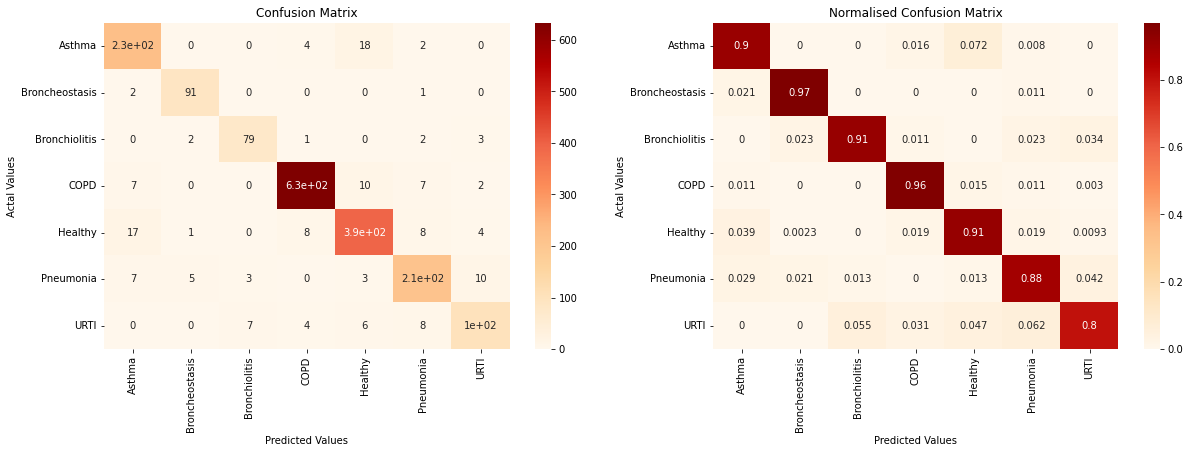

In [ ]:
    results=model.evaluate(X_test,Y_test,batch_size=batch,verbose=1)
    print('Test loss:', results[0])
    print('Test accuracy:', results[1])
    predicted=model.predict(X_test,batch_size=batch,verbose=1)
    Y_pred=predicted.argmax(axis=-1)
    Y_pred=predicted.argmax(axis=-1)
    Y_predicted=pd.DataFrame(Y_test,columns=['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    Y_ori=[];Asthma_t=0;Broncheostasis_t=0;Bronchiolitis_t=0;COPD_t=0;Healthy_t=0;Pneumonia_t=0;URTI_t=0;
    for index,row in tqdm(Y_predicted.iterrows()):
        if row['Asthma']==1:
          Asthma_t=Asthma_t+1
          Y_ori.append(0)
        elif row['Broncheostasis']==1:
          Broncheostasis_t=Broncheostasis_t+1
          Y_ori.append(1)
        elif row['Bronchiolitis']==1:
          Bronchiolitis_t=Bronchiolitis_t+1
          Y_ori.append(2)
        elif row['COPD']==1:
          COPD_t=COPD_t+1
          Y_ori.append(3)
        elif row['Healthy']==1:
          Healthy_t=Healthy_t+1
          Y_ori.append(4)
        elif row['Pneumonia']==1:
          Pneumonia_t=Pneumonia_t+1
          Y_ori.append(5)
        elif row['URTI']==1:
          URTI_t=URTI_t+1
          Y_ori.append(6)

    cm=confusion_matrix(Y_ori,Y_pred)
    cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
    print('Confusion Matrix');
    print(cm)
    
    cm_df = pd.DataFrame(cm,index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'], columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    plt.figure(100)
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    sns.heatmap(cm_df,annot=True,cmap="OrRd")
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    
    cm_df_norm = pd.DataFrame(cm_norm, index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],  columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    plt.subplot(122)
    sns.heatmap(cm_df_norm,annot=True,cmap="OrRd")
    plt.title('Normalised Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [ ]:

#loading the autoencoder model
#X_train_1,X_test,Y_train_1,Y_test=train_test_split(X,Y,test_size=0.1,random_state=10)
from tensorflow.keras.models import Model
import tensorflow as tf
model.load_weights("/content/gdrive/MyDrive/all_disease_classification/train_on_15_06_22/fold_1_2022_06_15_22_41_56.h5")
#model.load_weights
out_dense= Model(inputs=model.input,outputs=model.get_layer('dense').output)
Y_denseout = out_dense.predict(X_test)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,learning_rate='auto',init='random')
Y_embedded = tsne.fit_transform(Y_denseout)
Y_predicted=pd.DataFrame(Y_test,columns=['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
Y_ori=[];Asthma_t=0;Broncheostasis_t=0;Bronchiolitis_t=0;COPD_t=0;Healthy_t=0;Pneumonia_t=0;URTI_t=0;
for index,row in tqdm(Y_predicted.iterrows()):
   if row['Asthma']==1:
     Asthma_t=Asthma_t+1
     Y_ori.append(0)
   elif row['Broncheostasis']==1:
      Broncheostasis_t=Broncheostasis_t+1
      Y_ori.append(1)
   elif row['Bronchiolitis']==1:
      Bronchiolitis_t=Bronchiolitis_t+1
      Y_ori.append(2)
   elif row['COPD']==1:
       COPD_t=COPD_t+1
       Y_ori.append(3)
   elif row['Healthy']==1:
       Healthy_t=Healthy_t+1
       Y_ori.append(4)
   elif row['Pneumonia']==1:
       Pneumonia_t=Pneumonia_t+1
       Y_ori.append(5)
   elif row['URTI']==1:
      URTI_t=URTI_t+1
      Y_ori.append(6)

q=np.array(Y_ori)
label_l=[]
for i in range (X_test.shape[0]):
  if q[i]==0:
    label_l.append('Asthma')
  elif q[i]==1:
    label_l.append('Broncheostasis')
  elif q[i]==2:
    label_l.append('Bronchiolitis')
  elif q[i]==3:
    label_l.append('COPD')
  elif q[i]==4:
    label_l.append('Healthy')
  elif q[i]==5:
    label_l.append('Pneumonia')
  elif q[i]==6:
    label_l.append('URTI')

Label_ar=np.array(label_l)

1891it [00:00, 16146.22it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 't-SNE plot After applying Lightweight CNN')

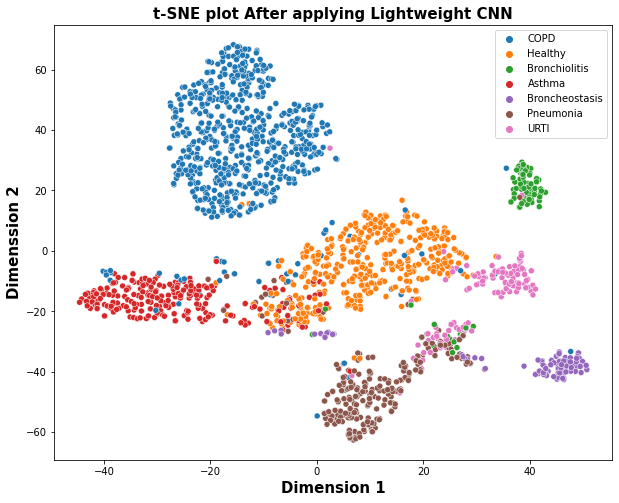

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.scatterplot(Y_embedded[:,0], Y_embedded[:,1], hue=Label_ar)
plt.xlabel("Dimension 1",fontweight ='bold', fontsize = 15);plt.ylabel("Dimenssion 2",fontweight ='bold', fontsize = 15)
plt.title('t-SNE plot After applying Lightweight CNN',fontweight ='bold', fontsize = 15)

***k-fold Cross validation***

In [ ]:
from pytz import timezone 
from datetime import datetime
import random
from datetime import datetime
import seaborn as sns
from sklearn.metrics import classification_report
id=[42,20,16];batch=256;
for fold in range (3): 
    #p=random.randint(1,42)
    p=id[fold]
    print('Random_seed_value== '+str(p))
    X_train_1,X_test,Y_train_1,Y_test=train_test_split(X,Y,test_size=0.1,random_state=p)
    X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=p)
    print("================================================================================================")
    print(f'Fold--------------> {fold+1}')
    from keras import backend as Ke
    Ke.clear_session()
    model = mobile_inception(dim, output_neurons, output_activation)
    opt =tf.keras.optimizers.Adam(learning_rate=0.008) 
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

    history = model.fit(X_train, Y_train, batch_size=batch, epochs=400, verbose=1,validation_data=(X_val, Y_val))#,callbacks=[custom_early_stopping])    
    plt.figure(fold+1)
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.plot(history.history['loss'],'b--')
    plt.plot(history.history['val_loss'],'g--')
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
 
    plt.subplot(122)
    plt.plot(history.history['accuracy'],'b--')
    plt.plot(history.history['val_accuracy'],'g--')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()   

    results=model.evaluate(X_test,Y_test,batch_size=batch,verbose=1)
    print('Test loss:', results[0])
    print('Test accuracy:', results[1])

    predicted=model.predict(X_test,batch_size=batch,verbose=1)
    Y_pred=predicted.argmax(axis=-1)
    Y_pred=predicted.argmax(axis=-1)
    Y_predicted=pd.DataFrame(Y_test,columns=['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    Y_ori=[];Asthma_t=0;Broncheostasis_t=0;Bronchiolitis_t=0;COPD_t=0;Healthy_t=0;Pneumonia_t=0;URTI_t=0;
    for index,row in tqdm(Y_predicted.iterrows()):
        if row['Asthma']==1:
          Asthma_t=Asthma_t+1
          Y_ori.append(0)
        elif row['Broncheostasis']==1:
          Broncheostasis_t=Broncheostasis_t+1
          Y_ori.append(1)
        elif row['Bronchiolitis']==1:
          Bronchiolitis_t=Bronchiolitis_t+1
          Y_ori.append(2)
        elif row['COPD']==1:
          COPD_t=COPD_t+1
          Y_ori.append(3)
        elif row['Healthy']==1:
          Healthy_t=Healthy_t+1
          Y_ori.append(4)
        elif row['Pneumonia']==1:
          Pneumonia_t=Pneumonia_t+1
          Y_ori.append(5)
        elif row['URTI']==1:
          URTI_t=URTI_t+1
          Y_ori.append(6)

    cm=confusion_matrix(Y_ori,Y_pred)
    cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
    print('Confusion Matrix');
    print(cm)
    
    cm_df = pd.DataFrame(cm,index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'], columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    plt.figure(100+fold)
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    sns.heatmap(cm_df,annot=True,cmap="OrRd")
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    
    cm_df_norm = pd.DataFrame(cm_norm, index = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'],  columns = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI'])
    plt.subplot(122)
    sns.heatmap(cm_df_norm,annot=True,cmap="OrRd")
    plt.title('Normalised Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    #target_names = ['Asthma','Broncheostasis','Bronchiolitis','COPD','Healthy','Pneumonia','URTI']
    #print(classification_report(Y_test, Y_pred, target_names=target_names))
    
    ind_time = datetime.now(timezone("Asia/Kolkata")).strftime('%Y_%m_%d_%H_%M_%S')

    # save the plot varriables
    train_loss=history.history['loss']; filepath_tloss=new_loc+'/train_loss_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_tloss,train_loss)
    val_loss=history.history['val_loss']; filepath_vloss=new_loc+'/val_loss_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_vloss,val_loss)
    acc=history.history['accuracy'];      filepath_tacc=new_loc+'/train_acc_fold_'+ str(fold+1) +'_'+str(ind_time)+'.txt'; np.savetxt(filepath_tacc,acc)
    val_acc=history.history['val_accuracy']; filepath_vacc=new_loc+'/val_acc_fold_'+ str(fold+1)+'_'+str(ind_time)+'.txt'; np.savetxt(filepath_vacc,val_acc)
    # save model
    model.save_weights(new_loc+'/fold_'+str(fold+1)+'_'+str(ind_time)+'.h5')
    print("================================================================================================")
